<a href="https://colab.research.google.com/github/Kirtanthapa02/AssemblerInC/blob/main/My_Image_Style_Transfer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#packages used

import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from PIL import Image
import torchvision.models as models
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

In [ ]:
#using gpu if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if device.type == "cuda":
  imgsize = 256
else:
  imgsize = 128
print(imgsize)

128


In [ ]:
def ImageLoader(pathname):
    if isinstance(pathname, str):
        img = Image.open(pathname).convert('RGB')  # Fully load the image
        transform = transforms.Compose([
            transforms.Resize((imgsize, imgsize)),
            transforms.ToTensor()
        ])
        img = transform(img).unsqueeze(0)
        return img.to(device)

    elif isinstance(pathname, torch.Tensor):
        return pathname.to(device)

In [ ]:
# view image
def imageshow(img,title=None):
  img = img.cpu().clone()
  img = img.squeeze(0)
  transform = transforms.ToPILImage()
  img = transform(img)
  plt.figure()
  plt.imshow(img)
  if title is not None:
    plt.title(title)

In [ ]:
#Get the feature Extractor
import warnings
warnings.filterwarnings("ignore")
vgg = models.vgg19(pretrained=True).features.to(device).eval() # eval set all batchnorm and dropout
print(vgg.modules)

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:04<00:00, 123MB/s] 


<bound method Module.modules of Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): R

In [ ]:
# set all requires_grad to false
for param in vgg.parameters():
  param.requires_grad_(False)
print(vgg[0].weight.requires_grad)

False


In [ ]:
# Content loss module
class ContentLoss(nn.Module):
  def __init__(self,target):
    super(ContentLoss,self).__init__()
    self.target = target.detach()
    self.loss = 0
  def forward(self,input):
    self.loss = F.mse_loss(input,self.target)
    return input

In [ ]:
# function to calculate normalized gram matrix
def Gram_Matrix(input):
    b, c, h, w = input.size()
    features = input.view(b, c, h * w)
    gram = torch.bmm(features, features.transpose(1, 2))
    gram /= (c * h * w)  # No need to divide by batch size
    return gram

In [ ]:
class StyleLoss(nn.Module):
  def __init__(self,target):
    super(StyleLoss,self).__init__()
    self.target = Gram_Matrix(target).detach()
  def forward(self,input):
    gram_value = Gram_Matrix(input)
    self.loss = F.mse_loss(gram_value,self.target)
    return input

In [ ]:
class Normalization(nn.Module):
  def __init__(self,mean,std):
    super(Normalization,self).__init__()
    # Move mean and std to the same device as the input
    self.mean = torch.tensor(mean).view(-1,1,1).to(device)
    self.std = torch.tensor(std).view(-1,1,1).to(device)
  def forward(self,input):
    input = transforms.Resize((imgsize,imgsize))(input)
    return (input-self.mean)/self.std

In [ ]:
content_layers = ["conv4_2"]
style_layers = ["conv1_1","conv2_1","conv3_1","conv4_1","conv5_1"]

In [ ]:
def get_style_model(cnn, normalization_mean, normalization_std,
                               style_img,style_layers=style_layers):
    # normalization module
    normalization = Normalization(normalization_mean, normalization_std)

    # just in order to have an iterable access to or list of content/style
    # losses
    content_losses = []
    style_losses = []

    # assuming that ``cnn`` is a ``nn.Sequential``, so we make a new ``nn.Sequential``
    # to put in modules that are supposed to be activated sequentially
    model = nn.Sequential(normalization)

    i = 0  # increment every time we see a conv
    block = 1
    for layer in cnn.children():
        if isinstance(layer, nn.Conv2d):
            i += 1
            name = 'conv{}_{}'.format(block,i)
        elif isinstance(layer, nn.ReLU):
            name = 'relu{}_{}'.format(block,i)
            # The in-place version doesn't play very nicely with the ``ContentLoss``
            # and ``StyleLoss`` we insert below. So we replace with out-of-place
            # ones here.
            layer = nn.ReLU(inplace=False)
        elif isinstance(layer, nn.BatchNorm2d):
            name = 'bn{}_{}'.format(block,i)
        elif isinstance(layer, nn.MaxPool2d):
            name = 'pool{}_{}'.format(block,i)
            block += 1
            i = 0
        else:
            raise RuntimeError('Unrecognized layer: {}'.format(layer.__class__.__name__))

        model.add_module(name, layer)

        if name in style_layers:
            # add style loss:
            target_feature = model(style_img).detach()
            style_loss = StyleLoss(target_feature)
            model.add_module("style_loss{}_{}".format(block,i), style_loss)
            style_losses.append(style_loss)

    # now we trim off the layers after the last content and style losses
    for i in range(len(model) - 1, -1, -1):
        if isinstance(model[i], StyleLoss):
            break

    model = model[:(i + 1)]

    return model, style_losses, content_losses

In [ ]:
normalization_mean = torch.tensor([0.485, 0.456, 0.406]).to(device)
normalization_std = torch.tensor([0.229, 0.224, 0.225]).to(device)

In [ ]:
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ConvBlock, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, stride=1, padding_mode='circular'),
            nn.ReLU()
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, stride=1, padding_mode='circular'),
            nn.ReLU()
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(out_channels, out_channels, kernel_size=1, padding=0, stride=1, padding_mode='circular'),
            nn.ReLU()
        )
        self.apply(self._initialize_weights)

    def _initialize_weights(self, m):
        if isinstance(m, nn.Conv2d):
            nn.init.xavier_uniform_(m.weight)
            if m.bias is not None:
                nn.init.zeros_(m.bias)

    def forward(self, input):
        x = self.conv1(input)
        x = self.conv2(x)
        x = self.conv3(x)
        return x


In [ ]:
class UpSample(nn.Module):
    def __init__(self, num_channels):
        super(UpSample, self).__init__()
        self.upsample = nn.Upsample(scale_factor=2.0, mode="nearest")

    def forward(self, input):
        x = self.upsample(input)
        return x


In [ ]:
# generating zi's
def generate_noise_tensors(M,K,batch_size=1,channels=3):
  noise_tensors = []
  for i in range(0,K):
    size = int(M / (2**i))
    zi = torch.randn(batch_size,channels,size,size).to(device)
    noise_tensors.append(zi)
  return noise_tensors

In [ ]:
# Joining textures
def Join_Features(z1,z2):
  return torch.cat([z1,z2],dim=1)

# Texture Generator

In [ ]:
# creating convblock for each of the zi's so parameters were more so 1st approach not good approach
class GeneratorNetwork(nn.Module):
  def __init__(self,M,K):
    super(GeneratorNetwork,self).__init__()
    self.img_size = M
    self.z_num = K
    for i in range(1,K+1):
      setattr(self,'ConvBlock'+str(i),ConvBlock(in_channels=3,out_channels=8))
    for i in range(1,K):
      setattr(self,'IntermediateConvBlock'+str(i),ConvBlock(in_channels=8*(i+1),out_channels=8*(i+1)))
      setattr(self,'UpSample'+str(i),UpSample(num_channels=8*i))
    self.final_conv = nn.Conv2d(in_channels=8*K,out_channels=3,kernel_size=3,stride=1,padding=1,padding_mode="circular")

  def forward(self,input=None):
    noise_tensors = list(reversed(generate_noise_tensors(self.img_size,self.z_num)))
    outputs = []
    for i,image in enumerate(noise_tensors):
      output = getattr(self,'ConvBlock'+str(i+1))(image)
      outputs.append(output)
      if len(outputs) > 1:
        output1 = outputs.pop()
        output2 = outputs.pop() # less resolution image
        output2 = getattr(self,'UpSample'+str(i))(output2)
        new_image = Join_Features(output1,output2)
        output = getattr(self,'IntermediateConvBlock'+str(i))(new_image)
        outputs.append(output)
    #output = getattr(self,'UpSample'+str(len(noisy_image)))(outputs.pop())
    output = self.final_conv(output)
    return output

In [ ]:
def train_generator_with_style_transfer(generator, cnn, normalization_mean, normalization_std,
                                        style_image, num_steps=1000,
                                        lr=0.001):

    # Set generator to train mode
    generator.train()

    model_vgg, style_losses, content_losses = get_style_model(
        cnn, normalization_mean, normalization_std, style_image)
    model_vgg.eval()
    for param in model_vgg.parameters():
        param.requires_grad = False

    # Optimizer only for generator parameters
    optimizer = torch.optim.Adam(generator.parameters(), lr=lr)

    for step in range(1, num_steps + 1):
        optimizer.zero_grad()

        generated_img = generator()

        model_vgg(generated_img)

        total_loss = sum(sl.loss for sl in style_losses)
        # Backpropagate
        total_loss.backward()
        optimizer.step()

        if step % 100 == 0 or step == 1:
            print(f"[Step {step}] Style Loss: {total_loss.item():.4f}")

        #Final result
    generator.eval()
    with torch.no_grad():
        final_img = generator().clamp(0, 1)
    return final_img


In [ ]:
textureNetwork = GeneratorNetwork(imgsize,5).to(device)

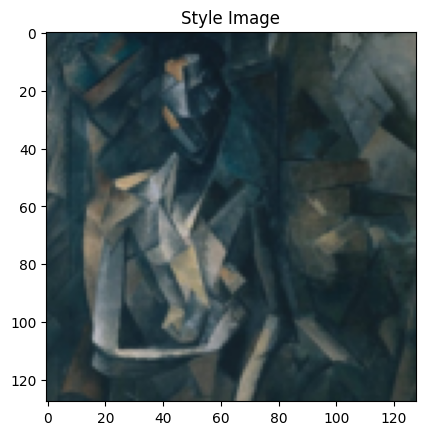

In [ ]:
style = ImageLoader("picasso.jpg")
imageshow(style,"Style Image")

In [ ]:
output = train_generator_with_style_transfer(
    textureNetwork, vgg, normalization_mean, normalization_std,
    style, num_steps=3000)

[Step 1] Style Loss: 0.0197
[Step 100] Style Loss: 0.0029
[Step 200] Style Loss: 0.0011
[Step 300] Style Loss: 0.0011
[Step 400] Style Loss: 0.0009
[Step 500] Style Loss: 0.0009
[Step 600] Style Loss: 0.0008
[Step 700] Style Loss: 0.0007
[Step 800] Style Loss: 0.0011
[Step 900] Style Loss: 0.0009
[Step 1000] Style Loss: 0.0007
[Step 1100] Style Loss: 0.0007
[Step 1200] Style Loss: 0.0008
[Step 1300] Style Loss: 0.0008
[Step 1400] Style Loss: 0.0006
[Step 1500] Style Loss: 0.0007
[Step 1600] Style Loss: 0.0007
[Step 1700] Style Loss: 0.0006
[Step 1800] Style Loss: 0.0008
[Step 1900] Style Loss: 0.0006
[Step 2000] Style Loss: 0.0008
[Step 2100] Style Loss: 0.0007
[Step 2200] Style Loss: 0.0009
[Step 2300] Style Loss: 0.0007
[Step 2400] Style Loss: 0.0006
[Step 2500] Style Loss: 0.0006
[Step 2600] Style Loss: 0.0005
[Step 2700] Style Loss: 0.0006
[Step 2800] Style Loss: 0.0005
[Step 2900] Style Loss: 0.0006
[Step 3000] Style Loss: 0.0005


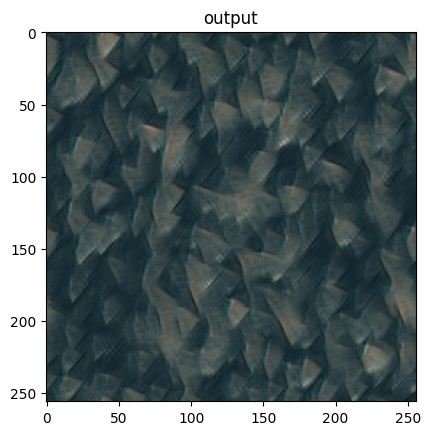

In [ ]:
imageshow(output,"output")

# Style transfer with one content image

In [ ]:
def get_style_model_and_losses(cnn, normalization_mean, normalization_std,
                               style_img, content_img,
                               content_layers=content_layers,
                               style_layers=style_layers):
    # normalization module
    normalization = Normalization(normalization_mean, normalization_std)

    # just in order to have an iterable access to or list of content/style
    # losses
    content_losses = []
    style_losses = []

    # assuming that ``cnn`` is a ``nn.Sequential``, so we make a new ``nn.Sequential``
    # to put in modules that are supposed to be activated sequentially
    model = nn.Sequential(normalization)

    i = 0  # increment every time we see a conv
    block = 1
    for layer in cnn.children():
        if isinstance(layer, nn.Conv2d):
            i += 1
            name = 'conv{}_{}'.format(block,i)
        elif isinstance(layer, nn.ReLU):
            name = 'relu{}_{}'.format(block,i)
            # The in-place version doesn't play very nicely with the ``ContentLoss``
            # and ``StyleLoss`` we insert below. So we replace with out-of-place
            # ones here.
            layer = nn.ReLU(inplace=False)
        elif isinstance(layer, nn.BatchNorm2d):
            name = 'bn{}_{}'.format(block,i)
        elif isinstance(layer, nn.MaxPool2d):
            name = 'pool{}_{}'.format(block,i)
            block += 1
            i = 0
        else:
            raise RuntimeError('Unrecognized layer: {}'.format(layer.__class__.__name__))

        model.add_module(name, layer)

        if name in content_layers:
            # add content loss:
            target = model(content_img).detach()
            content_loss = ContentLoss(target)
            model.add_module("content_loss{}_{}".format(block,i), content_loss)
            content_losses.append(content_loss)

        if name in style_layers:
            # add style loss:
            target_feature = model(style_img).detach()
            style_loss = StyleLoss(target_feature)
            model.add_module("style_loss{}_{}".format(block,i), style_loss)
            style_losses.append(style_loss)

    # now we trim off the layers after the last content and style losses
    for i in range(len(model) - 1, -1, -1):
        if isinstance(model[i], ContentLoss) or isinstance(model[i], StyleLoss):
            break

    model = model[:(i + 1)]

    return model, style_losses, content_losses

In [ ]:
def generate_images(image, noise_tensors):
    images = []
    for i in range(len(noise_tensors)):
        H = noise_tensors[i].shape[2]
        W = noise_tensors[i].shape[3]
        resized = F.interpolate(image, size=(H, W), mode='bilinear', align_corners=False).to(noise_tensors[i].device)
        noise_with_content = Join_Features(noise_tensors[i], resized)
        images.append(noise_with_content)
    return images

In [ ]:
# creating convblock for each of the zi's so parameters were more so 1st approach not good approach
class GeneratorNetwork(nn.Module):
  def __init__(self,M,K):
    super(GeneratorNetwork,self).__init__()
    self.img_size = M
    self.z_num = K
    for i in range(1,K+1):
      setattr(self,'ConvBlock'+str(i),ConvBlock(in_channels=6,out_channels=8))
    for i in range(1,K):
      setattr(self,'IntermediateConvBlock'+str(i),ConvBlock(in_channels=8*(i+1),out_channels=8*(i+1)))
      setattr(self,'UpSample'+str(i),UpSample(num_channels=8*i))
    self.final_conv = nn.Conv2d(in_channels=8*K,out_channels=3,kernel_size=3,stride=1,padding=1,padding_mode="circular")
    self._initialize_weights()

  def _initialize_weights(self):
    for m in self.modules():
      if isinstance(m, nn.Conv2d):
        nn.init.xavier_uniform_(m.weight)
        if m.bias is not None:
          nn.init.zeros_(m.bias)

  def forward(self,input):
    batch_size = input.size(0)
    noise_tensors = generate_noise_tensors(self.img_size,self.z_num,batch_size=batch_size)
    noisy_image = list(reversed(generate_images(input,noise_tensors)))
    outputs = []
    for i,image in enumerate(noisy_image):
      output = getattr(self,'ConvBlock'+str(i+1))(image)
      outputs.append(output)
      if len(outputs) > 1:
        output1 = outputs.pop()
        output2 = outputs.pop() # less resolution image
        output2 = getattr(self,'UpSample'+str(i))(output2)
        new_image = Join_Features(output1,output2)
        output = getattr(self,'IntermediateConvBlock'+str(i))(new_image)
        outputs.append(output)
    #output = getattr(self,'UpSample'+str(len(noisy_image)))(outputs.pop())
    output = self.final_conv(output)
    return output

In [ ]:
def train_generator_with_style_transfer(generator, cnn, normalization_mean, normalization_std,
                                        content_image, style_image, num_steps=1000,
                                        style_weight=1e5, content_weight=10, lr=5e-3,):

    # Set generator to train mode

    model_vgg, style_losses, content_losses = get_style_model_and_losses(
        cnn, normalization_mean, normalization_std, style_image, content_image)
    model_vgg.eval()
    for param in model_vgg.parameters():
        param.requires_grad = False

    # Optimizer only for generator parameters
    optimizer = torch.optim.Adam(generator.parameters(), lr=lr)

    for step in range(1, num_steps + 1):
        generator.train()
        optimizer.zero_grad()

        generated_img = generator(content_image)

        model_vgg(generated_img)

        style_score = sum(sl.loss for sl in style_losses)
        content_score = sum(cl.loss for cl in content_losses)
        total_loss = style_weight * style_score + content_weight * content_score

        # Backpropagate
        total_loss.backward()
        optimizer.step()

        if step % 100 == 0 or step == 1:
            print(f"[Step {step}] Style Loss: {style_score.item():.4f}, "
                  f"Content Loss: {content_score.item():.4f}, Total: {total_loss.item():.4f}")

    #Final result
        generator.eval()
        with torch.no_grad():
            final_img = generator(content_image).clamp(0, 1)

    return final_img


In [ ]:
testNetwork = GeneratorNetwork(imgsize,5).to(device)

In [ ]:
content_image = ImageLoader("image10.jpg")
style_image = ImageLoader("picasso.jpg")

In [ ]:
output = train_generator_with_style_transfer(
    testNetwork, vgg, normalization_mean, normalization_std,
    content_image, style_image, num_steps=3000, lr=0.001,style_weight=1e8,content_weight=1
)

[Step 1] Style Loss: 0.0214, Content Loss: 40.1486, Total: 2139595.2500
[Step 100] Style Loss: 0.0021, Content Loss: 55.2167, Total: 213615.4219
[Step 200] Style Loss: 0.0010, Content Loss: 54.0812, Total: 104366.1641
[Step 300] Style Loss: 0.0011, Content Loss: 61.0929, Total: 107544.6719
[Step 400] Style Loss: 0.0007, Content Loss: 59.0654, Total: 72076.9375
[Step 500] Style Loss: 0.0008, Content Loss: 55.8585, Total: 78851.9141
[Step 600] Style Loss: 0.0010, Content Loss: 63.3528, Total: 95192.9688
[Step 700] Style Loss: 0.0006, Content Loss: 58.6344, Total: 58599.2227
[Step 800] Style Loss: 0.0006, Content Loss: 60.0657, Total: 64840.7852
[Step 900] Style Loss: 0.0005, Content Loss: 60.4060, Total: 54874.9102
[Step 1000] Style Loss: 0.0006, Content Loss: 58.1000, Total: 61316.1914
[Step 1100] Style Loss: 0.0005, Content Loss: 60.2847, Total: 54235.9180
[Step 1200] Style Loss: 0.0005, Content Loss: 60.9580, Total: 54164.0117
[Step 1300] Style Loss: 0.0005, Content Loss: 58.8569, Tot

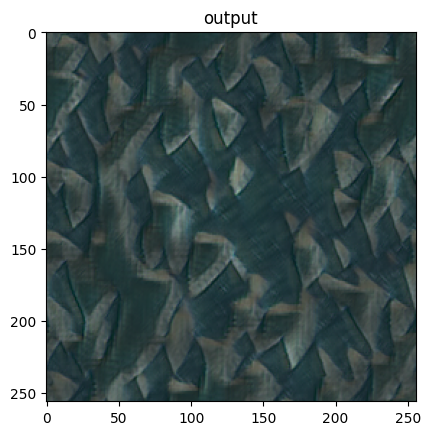

In [ ]:
imageshow(output,"output")

[Step 1] Style Loss: 0.0004, Content Loss: 54.0009, Total: 967.1106
[Step 100] Style Loss: 0.0004, Content Loss: 54.5042, Total: 922.1875
[Step 200] Style Loss: 0.0004, Content Loss: 55.6486, Total: 931.5303
[Step 300] Style Loss: 0.0004, Content Loss: 54.2276, Total: 946.5903
[Step 400] Style Loss: 0.0004, Content Loss: 55.1920, Total: 969.7949
[Step 500] Style Loss: 0.0006, Content Loss: 53.0200, Total: 1086.0846
[Step 600] Style Loss: 0.0004, Content Loss: 53.8245, Total: 892.3038
[Step 700] Style Loss: 0.0003, Content Loss: 53.5078, Total: 872.2224
[Step 800] Style Loss: 0.0004, Content Loss: 52.5169, Total: 920.8824
[Step 900] Style Loss: 0.0004, Content Loss: 53.1044, Total: 950.6917
[Step 1000] Style Loss: 0.0004, Content Loss: 54.3081, Total: 902.6067
[Step 1100] Style Loss: 0.0005, Content Loss: 55.3802, Total: 1043.9126
[Step 1200] Style Loss: 0.0004, Content Loss: 53.9008, Total: 904.7830
[Step 1300] Style Loss: 0.0004, Content Loss: 51.0071, Total: 889.8647
[Step 1400] Styl

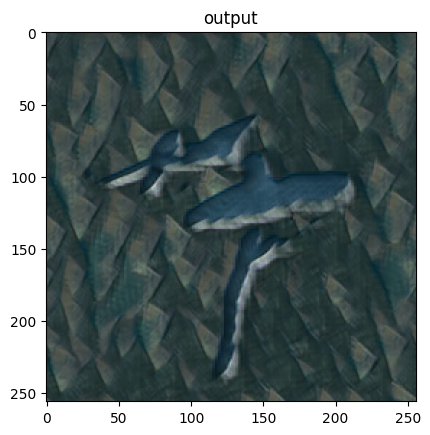

In [ ]:
output = train_generator_with_style_transfer(
    testNetwork, vgg, normalization_mean, normalization_std,
    content_image, style_image, num_steps=3000, lr=0.001,style_weight=1e6,content_weight=10
)
imageshow(output,"output")

[Step 1] Style Loss: 0.0004, Content Loss: 16.8041, Total: 21.0956
[Step 100] Style Loss: 0.0004, Content Loss: 16.3946, Total: 20.7288
[Step 200] Style Loss: 0.0005, Content Loss: 15.4320, Total: 20.2689
[Step 300] Style Loss: 0.0005, Content Loss: 14.9296, Total: 19.5233
[Step 400] Style Loss: 0.0004, Content Loss: 14.7967, Total: 18.8894
[Step 500] Style Loss: 0.0005, Content Loss: 13.5601, Total: 18.4283
[Step 600] Style Loss: 0.0004, Content Loss: 13.8093, Total: 18.0214
[Step 700] Style Loss: 0.0004, Content Loss: 13.2931, Total: 17.4699
[Step 800] Style Loss: 0.0004, Content Loss: 13.0336, Total: 17.1307
[Step 900] Style Loss: 0.0005, Content Loss: 12.1415, Total: 16.8330
[Step 1000] Style Loss: 0.0005, Content Loss: 11.9502, Total: 16.7039
[Step 1100] Style Loss: 0.0004, Content Loss: 11.6891, Total: 15.7973
[Step 1200] Style Loss: 0.0004, Content Loss: 11.2883, Total: 15.3536
[Step 1300] Style Loss: 0.0004, Content Loss: 11.0382, Total: 15.4146
[Step 1400] Style Loss: 0.0004, 

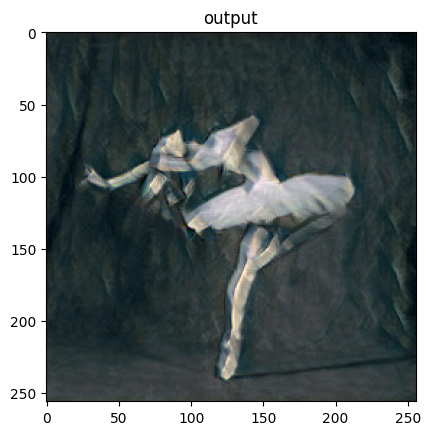

In [ ]:
output = train_generator_with_style_transfer(
    testNetwork, vgg, normalization_mean, normalization_std,
    content_image, style_image, num_steps=3000, lr=0.001,style_weight=1e4,content_weight=1
)
imageshow(output,"output")

In [ ]:
output = train_generator_with_style_transfer(
    testNetwork, vgg, normalization_mean, normalization_std,
    content_image, style_image, num_steps=3000, lr=0.001,style_weight=1e8,content_weight=100
)

[Step 1] Style Loss: 0.0004, Content Loss: 9.7895, Total: 459.7140
[Step 100] Style Loss: 0.0002, Content Loss: 23.2926, Total: 249.5882
[Step 200] Style Loss: 0.0002, Content Loss: 26.0469, Total: 195.4038
[Step 300] Style Loss: 0.0002, Content Loss: 26.6349, Total: 190.8126
[Step 400] Style Loss: 0.0002, Content Loss: 28.1668, Total: 193.8034
[Step 500] Style Loss: 0.0001, Content Loss: 28.1290, Total: 165.1180
[Step 600] Style Loss: 0.0001, Content Loss: 28.5664, Total: 160.0215
[Step 700] Style Loss: 0.0001, Content Loss: 29.4009, Total: 152.3384
[Step 800] Style Loss: 0.0001, Content Loss: 29.0081, Total: 149.5889
[Step 900] Style Loss: 0.0001, Content Loss: 30.6761, Total: 164.9791
[Step 1000] Style Loss: 0.0001, Content Loss: 30.1443, Total: 136.7474
[Step 1100] Style Loss: 0.0001, Content Loss: 30.8553, Total: 124.4387
[Step 1200] Style Loss: 0.0001, Content Loss: 29.8001, Total: 152.9907
[Step 1300] Style Loss: 0.0001, Content Loss: 29.7947, Total: 156.1628
[Step 1400] Style L

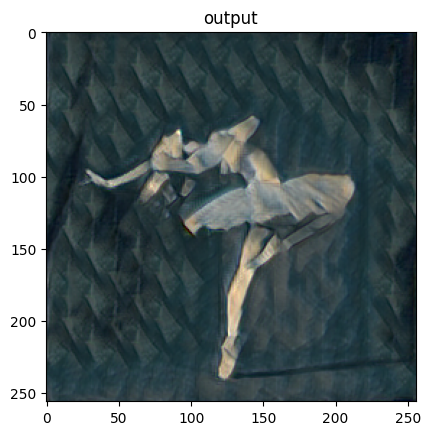

In [ ]:
imageshow(output,"output")

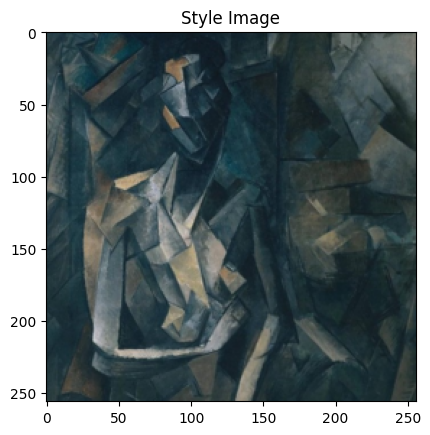

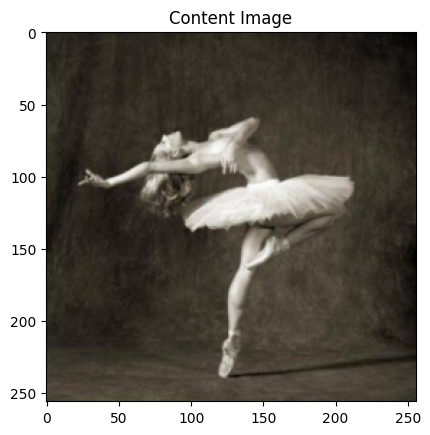

In [ ]:
imageshow(style_image,"Style Image")
imageshow(content_image,"Content Image")

# We will train with batch of images

In [ ]:
#mount drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
class CustomImageDataset(Dataset):
    def __init__(self, image_dir, transform=None):
        self.image_paths = [os.path.join(image_dir, f) for f in os.listdir(image_dir)]
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        img = Image.open(img_path).convert('RGB')
        if self.transform:
            img = self.transform(img)
        return img


In [ ]:
# getting data using dataloader
transform = transforms.Compose([
    transforms.Resize((imgsize,imgsize)),
    transforms.ToTensor(),
])
content_images = CustomImageDataset(image_dir="/content/drive/MyDrive/Colab Notebooks/Datasets/CustomImageDataset/Content Images",transform=transform)
style_images = ImageLoader("/content/drive/MyDrive/Colab Notebooks/Datasets/CustomImageDataset/Style Images/picasso.jpg")

In [ ]:
load_content = DataLoader(content_images,batch_size=16,shuffle=True)

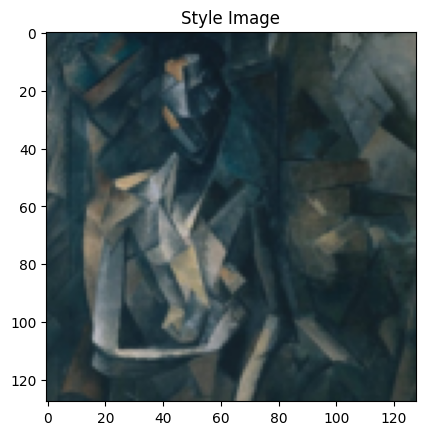

In [ ]:
imageshow(style_images,"Style Image")

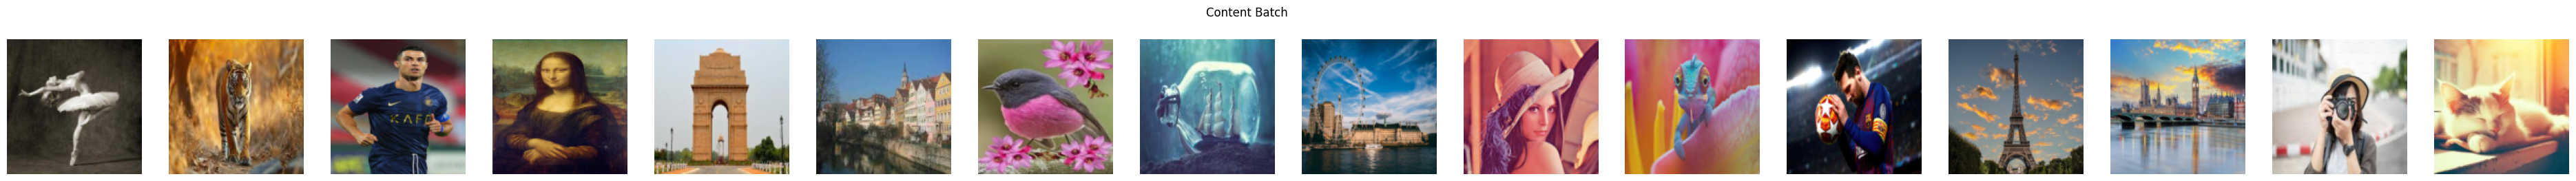

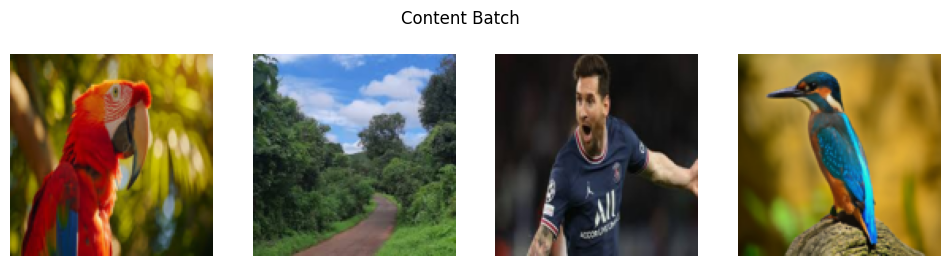

In [ ]:
import matplotlib.pyplot as plt

def show_batch_images(images, title="Batch Images"):
    # images: tensor of shape (B, C, H, W)
    batch_size = images.size(0)

    fig, axes = plt.subplots(1, batch_size, figsize=(batch_size * 3, 3))
    fig.suptitle(title)

    for i in range(batch_size):
        img = images[i].clamp(0,1)  # If unnormalized already
        img = transforms.ToPILImage()(img)
        axes[i].imshow(img)
        axes[i].axis('off')

    plt.show()

# Now show one batch
for batches in load_content:
    show_batch_images(batches, title="Content Batch")



In [ ]:
# for batches in load_content:
#   print(batches[0].shape)
#   #img = unnormalize(batches[0], mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
#   imageshow(batches[0],"output")
#   break

In [ ]:
#defining each block used in texture networks
class ConvBlock(nn.Module):
  def __init__(self,in_channels,out_channels):
    super(ConvBlock,self).__init__()
    self.conv1 = nn.Sequential(nn.Conv2d(in_channels,out_channels
                                         ,kernel_size=3,padding_mode='circular',
                                         padding=1,stride=1),nn.BatchNorm2d(out_channels),nn.ReLU())
    self.conv2 = nn.Sequential(nn.Conv2d(out_channels,out_channels
                                         ,kernel_size=3,padding_mode='circular',
                                         padding=1,stride=1),nn.BatchNorm2d(out_channels),nn.ReLU())
    self.conv3 = nn.Sequential(nn.Conv2d(out_channels,out_channels
                                         ,kernel_size=1,padding_mode='circular',
                                         padding=0,stride=1),nn.BatchNorm2d(out_channels),nn.ReLU())
    self.batchnorm = nn.BatchNorm2d(out_channels)

    self.apply(self._initialize_weights)

  def _initialize_weights(self,m):
    if isinstance(m,nn.Conv2d):
      nn.init.xavier_uniform_(m.weight)
      if m.bias is not None:
        nn.init.zeros_(m.bias)

  def forward(self,input):
    output = self.conv1(input)
    output = self.conv2(output)
    output = self.conv3(output)
    output = self.batchnorm(output)
    return output

In [ ]:
# # generating zi's
# def generate_noise_tensors(M,K,batch_size=1,channels=3):
#   noise_tensors = []
#   for i in range(0,K):
#     size = int(M / (2**i))
#     zi = torch.randn(batch_size,channels,size,size).to(device)
#     noise_tensors.append(zi)
#   return noise_tensors

In [ ]:
for tensor in generate_noise_tensors(imgsize,5,1):
  print(tensor.shape)

torch.Size([1, 3, 128, 128])
torch.Size([1, 3, 64, 64])
torch.Size([1, 3, 32, 32])
torch.Size([1, 3, 16, 16])
torch.Size([1, 3, 8, 8])


In [ ]:
# Joining textures
def Join_Features(z1,z2):
  return torch.cat([z1,z2],dim=1)

In [ ]:
# def generate_images(image, noise_tensors):
#     images = []
#     for i in range(len(noise_tensors)):
#         H = noise_tensors[i].shape[2]
#         W = noise_tensors[i].shape[3]
#         resized = F.interpolate(image, size=(H, W), mode='bilinear', align_corners=False).to(noise_tensors[i].device)
#         noise_with_content = Join_Features(noise_tensors[i], resized)
#         images.append(noise_with_content)
#     return images

In [ ]:
class UpSample(nn.Module):
  def __init__(self,num_channels):
    super(UpSample,self).__init__()
    self.upsample = nn.Upsample(scale_factor=2.0,mode="nearest")
    self.batchnorm = nn.BatchNorm2d(num_channels)
  def forward(self,input):
    output = self.upsample(input)
    output = self.batchnorm(output)
    return output

In [ ]:
# creating convblock for each of the zi's so parameters were more so 1st approach not good approach
class GeneratorNetwork(nn.Module):
  def __init__(self,M,K):
    super(GeneratorNetwork,self).__init__()
    self.img_size = M
    self.z_num = K
    for i in range(1,K+1):
      setattr(self,'ConvBlock'+str(i),ConvBlock(in_channels=6,out_channels=8))
    for i in range(1,K):
      setattr(self,'IntermediateConvBlock'+str(i),ConvBlock(in_channels=8*(i+1),out_channels=8*(i+1)))
      setattr(self,'UpSample'+str(i),UpSample(num_channels=8*i))
    self.final_conv = nn.Conv2d(in_channels=8*K,out_channels=3,kernel_size=3,stride=1,padding=1,padding_mode="circular")

  def forward(self,input):
    batch_size = input.size(0)
    noise_tensors = generate_noise_tensors(self.img_size,self.z_num,batch_size=batch_size)
    noisy_image = list(reversed(generate_images(input,noise_tensors)))
    outputs = []
    for i,image in enumerate(noisy_image):
      output = getattr(self,'ConvBlock'+str(i+1))(image)
      outputs.append(output)
      if len(outputs) > 1:
        output1 = outputs.pop()
        output2 = outputs.pop() # less resolution image
        output2 = getattr(self,'UpSample'+str(i))(output2)
        new_image = Join_Features(output1,output2)
        output = getattr(self,'IntermediateConvBlock'+str(i))(new_image)
        outputs.append(output)
    #output = getattr(self,'UpSample'+str(len(noisy_image)))(outputs.pop())
    output = self.final_conv(output)
    return output

In [ ]:
def get_style_model_and_losses(cnn, normalization_mean, normalization_std,
                               style_img, content_img,
                               content_layers=content_layers,
                               style_layers=style_layers):
    # normalization module
    normalization = Normalization(normalization_mean, normalization_std)

    # just in order to have an iterable access to or list of content/style
    # losses
    content_losses = []
    style_losses = []

    # assuming that ``cnn`` is a ``nn.Sequential``, so we make a new ``nn.Sequential``
    # to put in modules that are supposed to be activated sequentially
    model = nn.Sequential(normalization)

    i = 0  # increment every time we see a conv
    block = 1
    for layer in cnn.children():
        if isinstance(layer, nn.Conv2d):
            i += 1
            name = 'conv{}_{}'.format(block,i)
        elif isinstance(layer, nn.ReLU):
            name = 'relu{}_{}'.format(block,i)
            # The in-place version doesn't play very nicely with the ``ContentLoss``
            # and ``StyleLoss`` we insert below. So we replace with out-of-place
            # ones here.
            layer = nn.ReLU(inplace=False)
        elif isinstance(layer, nn.BatchNorm2d):
            name = 'bn{}_{}'.format(block,i)
        elif isinstance(layer, nn.MaxPool2d):
            name = 'pool{}_{}'.format(block,i)
            block += 1
            i = 0
        else:
            raise RuntimeError('Unrecognized layer: {}'.format(layer.__class__.__name__))

        model.add_module(name, layer)

        if name in content_layers:
            # add content loss:
            target = model(content_img).detach()
            content_loss = ContentLoss(target)
            model.add_module("content_loss{}_{}".format(block,i), content_loss)
            content_losses.append(content_loss)

        if name in style_layers:
            # add style loss:
            target_feature = model(style_img).detach()
            style_loss = StyleLoss(target_feature)
            model.add_module("style_loss{}_{}".format(block,i), style_loss)
            style_losses.append(style_loss)

    # now we trim off the layers after the last content and style losses
    for i in range(len(model) - 1, -1, -1):
        if isinstance(model[i], ContentLoss) or isinstance(model[i], StyleLoss):
            break

    model = model[:(i + 1)]

    return model, style_losses, content_losses

In [ ]:
genNetwork = GeneratorNetwork(imgsize,6).to(device)

In [ ]:
def lambda_lr(step):
    if step < 1000:
        return 1.0
    else:
        return 0.7 ** ((step - 1000) // 200 + 1)

# Define optimizer ONCE for the generator
optimizer = torch.optim.Adam(genNetwork.parameters(), lr=0.01)
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda_lr)

In [ ]:
style_images = style_images.to(device)

In [ ]:
def batch_train_generator_with_style_transfer(generator, cnn, normalization_mean, normalization_std,
                                        content_img, style_img, optimizer, batch_num,
                                        style_weight=1e6, content_weight=1):

    generator.train()

    # model_vgg, style_losses, content_losses = get_style_model_and_losses(
    #     cnn, normalization_mean, normalization_std, style_img, content_img)
    # model_vgg.eval()
    # for param in model_vgg.parameters():
    #     param.requires_grad = False


    optimizer.zero_grad()

    generated_img = generator(content_img).clamp(0,1)

    model_vgg,style_losses,content_losses = get_style_model_and_losses(cnn, normalization_mean, normalization_std,
                               style_img, content_img,
                               content_layers=content_layers,
                               style_layers=style_layers)

    model_vgg.eval()
    for param in model_vgg.parameters():
        param.requires_grad = False

    model_vgg(generated_img)
    for i, sl in enumerate(style_losses):
      print(f"Style loss layer {i}: {sl.loss.item():.6f}")

    for i, cl in enumerate(content_losses):
        print(f"Content loss layer {i}: {cl.loss.item():.6f}")
    style_score = sum(sl.loss for sl in style_losses)
    content_score = sum(cl.loss for cl in content_losses)
    total_loss = style_weight * style_score + content_weight * content_score

        # Backpropagate
    total_loss.backward()
    optimizer.step()  # updates LR using global step behind the scenes

        # if step % 100 == 0 or step == 1:
        #     print(f"[Step {step}] Style Loss: {style_score.item():.4f}, "
        #           f"Content Loss: {content_score.item():.4f}, Total: {total_loss.item():.4f}")

    # optimizer.zero_grad()

    # generated_img = generator(content_img).clamp(0, 1)

    # model_vgg(generated_img)

    # style_score = sum(sl.loss for sl in style_losses)
    # content_score = sum(cl.loss for cl in content_losses)
    # total_loss = (style_weight * style_score + content_weight * content_score)/content_img.size(0)

    # total_loss.backward()
    # optimizer.step()

    print(f"[batch{batch_num}] Style Loss: {style_score.item():.4f}, "
          f"Content Loss: {content_score.item():.4f}, Total: {total_loss.item():.4f}")


In [ ]:
num_epoch = 2000
# num_steps = 300

for epoch in range(num_epoch):
    current_lr = scheduler.get_last_lr()[0]
    print(f"\n[Epoch {epoch + 1}/{num_epoch}] Learning Rate: {current_lr:.6f}")
    for i, content_images in enumerate(load_content):
        print(f"Batch {i+1}/{len(load_content)}")
        content_images = content_images.to(device)
        batch_train_generator_with_style_transfer(
              genNetwork, vgg, normalization_mean, normalization_std,
              content_images, style_images, optimizer,batch_num=i+1
        )

    scheduler.step()


[Epoch 1/2000] Learning Rate: 0.010000
Batch 1/2
Style loss layer 0: 0.000062
Style loss layer 1: 0.000615
Style loss layer 2: 0.004432
Style loss layer 3: 0.031465
Style loss layer 4: 0.001745
Content loss layer 0: 194.049484
[batch1] Style Loss: 0.0383, Content Loss: 194.0495, Total: 38513.7930
Batch 2/2
Style loss layer 0: 0.000064
Style loss layer 1: 0.000667
Style loss layer 2: 0.004880
Style loss layer 3: 0.031929
Style loss layer 4: 0.002086
Content loss layer 0: 203.586212
[batch2] Style Loss: 0.0396, Content Loss: 203.5862, Total: 39829.7266

[Epoch 2/2000] Learning Rate: 0.010000
Batch 1/2
Style loss layer 0: 0.000073
Style loss layer 1: 0.001164
Style loss layer 2: 0.005037
Style loss layer 3: 0.035118
Style loss layer 4: 0.001880
Content loss layer 0: 192.201752
[batch1] Style Loss: 0.0433, Content Loss: 192.2018, Total: 43464.3281
Batch 2/2
Style loss layer 0: 0.000067
Style loss layer 1: 0.000835
Style loss layer 2: 0.003930
Style loss layer 3: 0.030665
Style loss layer 

KeyboardInterrupt: 

In [ ]:
genNetwork.eval()
with torch.no_grad():
  content = ImageLoader("image10.jpg")
  output = genNetwork(content).clamp(0,1)
imageshow(output,"output")

In [ ]:
# Save the trained generator model
torch.save(genNetwork.state_dict(), "trained_generator.pth")
print("✅ Generator model saved as 'trained_generator.pth'")

# Texture Generator

In [ ]:
# function to calculate normalized gram matrix
def Gram_Matrix(input):
  batchsize,channels,height,width = input.size()
  features = input.view(batchsize,channels,height*width)
  gram_value = torch.bmm(features,features.transpose(1,2))
  normalized_gram = gram_value.div(batchsize*channels*height*width)
  return normalized_gram

In [ ]:
class StyleLoss(nn.Module):
  def __init__(self,target):
    super(StyleLoss,self).__init__()
    self.target = Gram_Matrix(target).detach()
  def forward(self,input):
    gram_value = Gram_Matrix(input)
    self.loss = F.mse_loss(gram_value,self.target)
    return input

In [ ]:
class Normalization(nn.Module):
  def __init__(self,mean,std):
    super(Normalization,self).__init__()
    # Move mean and std to the same device as the input
    self.mean = torch.tensor(mean).view(-1,1,1).to(device)
    self.std = torch.tensor(std).view(-1,1,1).to(device)
  def forward(self,input):
    input = transforms.Resize((imgsize,imgsize))(input)
    return (input-self.mean)/self.std

In [ ]:
style_layers = ["conv1_1","conv2_1","conv3_1","conv4_1","conv5_1"]

In [ ]:
normalization_mean = torch.tensor([0.485, 0.456, 0.406]).to(device)
normalization_std = torch.tensor([0.229, 0.224, 0.225]).to(device)

In [ ]:
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ConvBlock, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, stride=1, padding_mode='circular'),
            nn.ReLU()
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, stride=1, padding_mode='circular'),
            nn.ReLU()
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(out_channels, out_channels, kernel_size=1, padding=0, stride=1, padding_mode='circular'),
            nn.ReLU()
        )

    def forward(self, input):
        x = self.conv1(input)
        x = self.conv2(x)
        x = self.conv3(x)
        return x


In [ ]:
class UpSample(nn.Module):
  def __init__(self,num_channels):
    super(UpSample,self).__init__()
    self.upsample = nn.Upsample(scale_factor=2.0,mode="nearest")
  def forward(self,input):
    output = self.upsample(input)
    return output

In [ ]:
# generating zi's
def generate_noise_tensors(M,K,channels=3):
  noise_tensors = []
  for i in range(0,K):
    size = int(M / (2**i))
    zi = torch.randn(1,channels,size,size).to(device)
    noise_tensors.append(zi)
  return noise_tensors

In [ ]:
# Joining textures
def Join_Features(z1,z2):
  return torch.cat([z1,z2],dim=1)

In [ ]:
# creating convblock for each of the zi's so parameters were more so 1st approach not good approach
class GeneratorNetwork(nn.Module):
  def __init__(self,M,K):
    super(GeneratorNetwork,self).__init__()
    self.img_size = M
    self.z_num = K
    for i in range(1,K+1):
      setattr(self,'ConvBlock'+str(i),ConvBlock(in_channels=3,out_channels=8))
    for i in range(1,K):
      setattr(self,'IntermediateConvBlock'+str(i),ConvBlock(in_channels=8*(i+1),out_channels=8*(i+1)))
      setattr(self,'UpSample'+str(i),UpSample(num_channels=8*i))
    self.final_conv = nn.Conv2d(in_channels=8*K,out_channels=3,kernel_size=3,stride=1,padding=1,padding_mode="circular")
    self._initialize_weights()

  def _initialize_weights(self):
    for m in self.modules():
      if isinstance(m, nn.Conv2d):
        nn.init.xavier_uniform_(m.weight)
        if m.bias is not None:
          nn.init.zeros_(m.bias)

  def forward(self,input=None):
    noise_tensors = list(reversed(generate_noise_tensors(self.img_size,self.z_num)))
    outputs = []
    for i,image in enumerate(noise_tensors):
      output = getattr(self,'ConvBlock'+str(i+1))(image)
      outputs.append(output)
      if len(outputs) > 1:
        output1 = outputs.pop()
        output2 = outputs.pop() # less resolution image
        output2 = getattr(self,'UpSample'+str(i))(output2)
        new_image = Join_Features(output1,output2)
        output = getattr(self,'IntermediateConvBlock'+str(i))(new_image)
        outputs.append(output)
    #output = getattr(self,'UpSample'+str(len(noisy_image)))(outputs.pop())
    output = self.final_conv(output)
    return output

In [ ]:
def train_generator_with_style_transfer(generator, cnn, normalization_mean, normalization_std,
                                        content_img, style_img, optimizer, scheduler,
                                        step, style_weight=1e5, content_weight=1):
    generator.train()

    model_vgg, style_losses, content_losses = get_style_model_and_losses(
        cnn, normalization_mean, normalization_std, style_img, content_img)
    model_vgg.eval()
    for param in model_vgg.parameters():
        param.requires_grad = False

    optimizer.zero_grad()

    generated_img = generator(content_img)
    model_vgg(generated_img)

    style_score = sum(sl.loss for sl in style_losses)
    content_score = sum(cl.loss for cl in content_losses)
    total_loss = style_weight * style_score + content_weight * content_score

    total_loss.backward()
    optimizer.step()
    scheduler.step()  # updates LR using global step behind the scenes

    if step % 100 == 0 or step == 1:
        print(f"[Step {step}] Style Loss: {style_score.item():.4f}, "
              f"Content Loss: {content_score.item():.4f}, Total: {total_loss.item():.4f}")


In [ ]:
genNetwork = GeneratorNetwork(imgsize,5).to(device)

In [ ]:
num_epoch = 1
num_steps = 300
for epoch in range(num_epoch):
  print(f"Epoch {epoch+1}/{num_epoch}")
  for i,content_images in enumerate(load_content):
    print(f"Batch {i+1}/{len(load_content)}")
    # load_content = iter(load_content)
    content_images = content_images.to(device)
    train_generator_with_style_transfer(
        genNetwork, vgg, normalization_mean, normalization_std,
        content_images, style_image, num_steps=2000
    )

In [ ]:
image = ImageLoader("image7.jpg")
train_generator_with_style_transfer(
  smallNetwork, vgg, normalization_mean, normalization_std,
        image, style_image, num_steps=300
  )

In [ ]:
imageshow(output,"output")

In [ ]:
# creating convblock for each of the zi's so parameters were more so 1st approach not good approach
class GeneratorNetwork(nn.Module):
  def __init__(self,M,K):
    super(GeneratorNetwork,self).__init__()
    self.img_size = M
    self.z_num = K
    for i in range(1,K+1):
      setattr(self,'ConvBlock'+str(i),ConvBlock(in_channels=6,out_channels=8))
    for i in range(1,K):
      setattr(self,'IntermediateConvBlock'+str(i),ConvBlock(in_channels=8*(i+1),out_channels=8*(i+1)))
      setattr(self,'UpSample'+str(i),UpSample(num_channels=8*i))
    self.final_conv = nn.Conv2d(in_channels=8*K,out_channels=3,kernel_size=3,stride=1,padding=1,padding_mode="circular")
    self._initialize_weights()

  def _initialize_weights(self):
    for m in self.modules():
      if isinstance(m, nn.Conv2d):
        nn.init.xavier_uniform_(m.weight)
        if m.bias is not None:
          nn.init.zeros_(m.bias)

  def forward(self,input):
    batch_size = input.size(0)
    noise_tensors = generate_noise_tensors(self.img_size,self.z_num,batch_size=batch_size)
    noisy_image = list(reversed(generate_images(input,noise_tensors)))
    outputs = []
    for i,image in enumerate(noisy_image):
      output = getattr(self,'ConvBlock'+str(i+1))(image)
      outputs.append(output)
      if len(outputs) > 1:
        output1 = outputs.pop()
        output2 = outputs.pop() # less resolution image
        output2 = getattr(self,'UpSample'+str(i))(output2)
        new_image = Join_Features(output1,output2)
        output = getattr(self,'IntermediateConvBlock'+str(i))(new_image)
        outputs.append(output)
    #output = getattr(self,'UpSample'+str(len(noisy_image)))(outputs.pop())
    output = self.final_conv(output)
    return output

In [ ]:
genNetwork = GeneratorNetwork(imgsize,5).to(device)

In [ ]:
genNetwork(style_image).shape

In [ ]:
genNetwork.eval()
with torch.no_grad():
  content = ImageLoader("image7.jpg")
  output = genNetwork(content).clamp(0,1)

In [ ]:
imageshow(output,"output")

In [ ]:
# once convblock, one intermediate block, one upsample
class SmallGeneratorNetwork(nn.Module):
  def __init__ (self,M,K):
    super(SmallGeneratorNetwork,self).__init__()
    self.imgsize = M
    self.num_noises = K
    self.conv_block = ConvBlock(in_channels=6,out_channels=8)
    self.intermediate_conv = ConvBlock(in_channels=16,out_channels=8)
    self.up_sample = UpSample()
    self.final_conv = nn.Conv2d(in_channels=8,out_channels=3,kernel_size=3,stride=1,padding=1,padding_mode="circular")

  def forward(self,input):
    batch_size = input.size(0)
    noise_tensors = generate_noise_tensors(self.imgsize,self.num_noises,batch_size=batch_size)
    noisy_image = list(reversed(generate_images(input,noise_tensors)))
    outputs = []
    for i,image in enumerate(noisy_image):
      output = self.conv_block(image)
      outputs.append(output)
      if len(outputs) > 1:
        output1 = outputs.pop()
        output2 = outputs.pop() # less resolution image
        output2 = UpSample()(output2)
        new_image = Join_Features(output1,output2)
        output = self.intermediate_conv(new_image)
        outputs.append(output)
    output = self.final_conv(output)
    return output